In [2]:
# Import libraries

import gzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectPercentile
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, f1_score
from scipy import stats
!pip install --quiet optuna
!pip install --quiet mlflow
import optuna
from sklearn.model_selection import train_test_split
import mlflow
from urllib.parse import urlparse
from mlflow.tracking import MlflowClient
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.9 MB/s eta 0:00:00


In [3]:
# Reading files

df_train = pd.DataFrame()
df_test = pd.DataFrame()

def read_files(df_train: pd.DataFrame, df_test: pd.DataFrame) -> list[pd.DataFrame]:
  with gzip.open('train.gz', 'r') as train_file:
    df_train = pd.read_csv(train_file)
    print(f"The train file contains {len(df_train)} rows"
    f" and {len(df_train.columns)} columns")

  with gzip.open('test.gz', 'r') as test_file:
    df_test = pd.read_csv(test_file)
    print(f"The test file contains {len(df_test)} rows"
    f" and {len(df_test.columns)} columns")
    return [df_train, df_test]

[df_train, df_test] = read_files(df_train, df_test)

The train file contains 40000 rows and 1001 columns
The test file contains 10000 rows and 1001 columns


In [4]:
# Data treatment and cleaning

def data_treatment(df: pd.DataFrame) -> pd.DataFrame:
  # Column 'alvo' is a category
  df['alvo'] = df['alvo'].astype('category')

  # Ensure all other columns are float64
  for index, dtype in enumerate(df.dtypes.values):
    if dtype != 'float64' and index != 1000:
      df[f"var{index+1}"] = df[f"var{index+1}"].astype('float64')

  return df

df_train = data_treatment(df_train)
df_test  = data_treatment(df_test)

def data_cleaning(df: pd.DataFrame, plot: bool=False) -> pd.DataFrame:
  # Removing duplicate rows
  print(f"Size of df before removing duplicates: {len(df)}")
  df.drop_duplicates(keep='first', inplace=True)
  print(f"Size of df after removing duplicates: {len(df)}\n")
  if plot:
    # Plot columns with most missing files
    plt.plot(range(0, len(df_train.columns[:-1])), count_missing[:-1])
    plt.suptitle(f"{len(df_train.columns)-1} columns with most missing values")
  return df

df_train = data_cleaning(df_train, False)
df_test  = data_cleaning(df_test, False)

# Which columns have most missing values?
count_missing = [0]*len(df_train.columns)
for index, col in enumerate(df_train.columns[:-1]):
  count_missing[index] = df_train[col].isna().sum()

Size of df before removing duplicates: 40000
Size of df after removing duplicates: 36096

Size of df before removing duplicates: 10000
Size of df after removing duplicates: 9237



In [5]:
def normalize(df: pd.DataFrame) -> pd.DataFrame:
  # Using RobustScaler to normalize dataset
  scaler = RobustScaler()

  target = df['alvo'].copy(deep=True)
  variables = df.drop('alvo', axis=1, inplace=False).copy(deep=True)
  
  X = np.array(variables)
  y = np.array(target)

  scaler = scaler.fit_transform(variables)

  # Replace with normalized
  df = pd.DataFrame(scaler, columns=variables.columns)

  # It's impossible to analyze visually 1000 box-plots (every column), 
  # we need to use a statistical approach to filter outliers:
  # Removing rows if any columns has Z-Score greater than 2.9
  df[(np.abs(stats.zscore(df)) < 2.9).all(axis=1)]

  # Don't normalize the classes
  df['alvo'] = target
  return df

df_train = normalize(df_train)
df_test  = normalize(df_test)

In [6]:
# Clearly some column intervals have clusters of missing values,
# let's drop these clusters. 
# To filter these columns, I'll use average as discriminator.

most_miss = []
miss_avg  = np.average(count_missing)
for index, value in enumerate(count_missing):
  if value > miss_avg:
    most_miss.append(f"var{index+1}")

df_train.drop(axis=1, labels=most_miss, inplace=True)
df_test.drop(axis=1, labels=most_miss, inplace=True)

Text(0.5, 0.98, 'Train dataset after removing 83 columns')

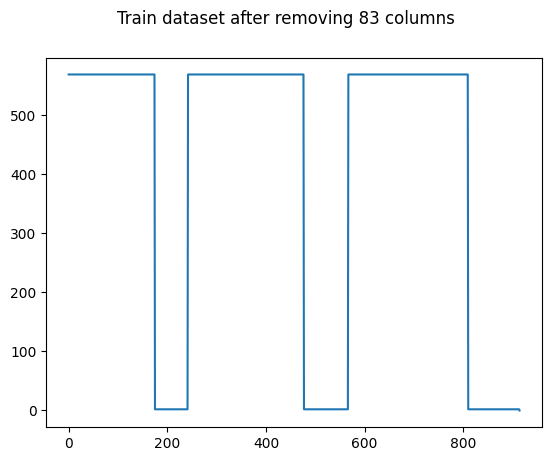

In [7]:
# It seems we've dropped the exceding missing values.

filtered_cols = []
for col in df_train.columns[:-1]:
  filtered_cols.append(df_train[col].isna().sum())

plt.plot(range(0, len(df_train.columns[:-1])), filtered_cols)
plt.suptitle(f"Train dataset after removing {1000-len(df_train.columns)-1} columns")

In [8]:
# Removing some rows with null data
def remove_null_rows(df_train: pd.DataFrame, df_test: pd.DataFrame) -> list[pd.DataFrame]:
  print(f"The train dataset before removing null rows has {len(df_train)} rows")
  df_train.dropna(how='any', inplace=True)
  print(f"The train dataset after removing null rows has {len(df_train)} rows\n")
  print(f"The test dataset before removing null rows has {len(df_test)} rows")
  df_test.dropna(how='any', inplace=True)
  print(f"The test dataset after removing null rows has {len(df_test)} rows")
  return [df_train, df_test]

[df_train, df_test] = remove_null_rows(df_train, df_test)

The train dataset before removing null rows has 36096 rows
The train dataset after removing null rows has 32131 rows

The test dataset before removing null rows has 9237 rows
The test dataset after removing null rows has 8407 rows


In [9]:
target = df_train['alvo']
variables = df_train.drop('alvo', axis=1, inplace=False)

X = np.array(variables)
y = np.array(target)

# Identifying the 100 most relevant variables using LDA
lda_clf = LinearDiscriminantAnalysis(n_components = 1)
lda_clf.fit(X, y)

# Sorting top 100 most important
top_100_feats = sorted(
    enumerate(
      abs(lda_clf.coef_[0]), start=1), 
      key = lambda x: x[1]
    )[:100]

In [18]:
top_100_feats = sorted(enumerate(abs(lda_clf.coef_[0]), start=1), key = lambda x: x[1])[:100]

def remove_unused_cols(df_train: pd.DataFrame, df_test: pd.DataFrame) -> list[pd.DataFrame]:
  # Remove columns which are not relevant according to LDA
  remove = set()
  remove_col = []
  for cols in top_100_feats:
    remove.add(cols[0])
  remove_list = ['var'+str(col) for col in range(1,1001) if col not in remove]

  for cols in most_miss:
    if cols in remove_list:
       remove_list.remove(cols)
  
  X_train = df_train.copy(deep=True)
  X_test = df_test.copy(deep=True)
  
  # Also remove the y ('alvo'), but copy before removing
  remove_list.append('alvo')
  y_train = X_train['alvo'].copy(deep=True)
  y_test = X_test['alvo'].copy(deep=True)

  X_train.drop(labels=remove_list, axis=1, inplace=True)
  X_test.drop(labels=remove_list, axis=1, inplace=True)

  return [X_train, X_test, y_train, y_test]

[X_train, X_test, y_train, y_test] = remove_unused_cols(df_train, df_test)

rfc = RandomForestClassifier(max_depth=2, random_state=0)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.4, random_state=0)

print("Accuracy on training set: %f" % rfc.score(X_train, y_train))
print("Accuracy on testing set: %f" % rfc.score(X_test, y_test))

Accuracy on training set: 0.862096
Accuracy on testing set: 0.870936


In [21]:
# Oversampling class '1', since it's too small
print(f"Training statistics before: {(y_train.to_list().count(0))} {(y_train.to_list().count(1))}")

over_sampler = SMOTE(random_state=0)
X_train, y_train = over_sampler.fit_resample(X_train, y_train)

print(f"Training target statistics: {(y_train.to_list().count(0))} {(y_train.to_list().count(1))}")
print(f"Testing target statistics: {(y_test.to_list().count(0))} {(y_test.to_list().count(1))}")

Training statistics before: 27700 4431
Training target statistics: 27700 27700
Testing target statistics: 4393 651


In [42]:
def print_auto_logged_info(r):
  tags = {k: v for k, v in r.data.tags.items() if not k.startswith("mlflow.")}
  artifacts = [f.path for f in MlflowClient().list_artifacts(r.info.run_id, "model")]
  print("run_id: {}".format(r.info.run_id))
  print("params: {}".format(r.data.params))
  print("metrics: {}".format(r.data.metrics))

def objective(trial):
  [X_train, X_test, y_train, y_test] = remove_unused_cols(df_train, df_test)
  n_estimators = trial.suggest_int('n_estimators', 10, 100)
  max_depth = trial.suggest_int('max_depth', 2, 16)
  percentile = trial.suggest_int('percentile', 1, 10, 9)
  criterion = trial.suggest_categorical('criterion', 
                                  {'entropy', 'log_loss', 'gini'})
  
  min_samples_split = trial.suggest_int('min_samples_split', 2, 20)

  rf = RandomForestClassifier(n_estimators=n_estimators,
                              criterion=criterion, 
                              min_samples_split=min_samples_split,
                              random_state=0, max_depth=max_depth)

  def confusion_matrix_scorer(y, y_pred):
    cm = confusion_matrix(y, y_pred)
    return cm[0][0] + cm[1][1]

  with mlflow.start_run() as run:
    rf.fit(X_train, y_train)
    X_train = SelectPercentile(percentile=percentile).fit_transform(X_train, y_train)
    rf_predict = rf.predict(X_test)

    mlflow.log_param("Percentile", percentile)
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)
    mlflow.log_param("criterion", criterion)
    mlflow.log_param("min_samples_split", min_samples_split)

    mlflow.log_metric("auc", roc_auc_score(y_test, rf_predict))
    mlflow.log_metric("cfm", confusion_matrix_scorer(y_test, rf_predict))
    mlflow.log_metric("acc", accuracy_score(y_test, rf_predict))
    mlflow.log_metric("f1", f1_score(y_test, rf_predict))

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
    if tracking_url_type_store != "file":
      mlflow.sklearn.log_model(rf, "model", registered_model_name="RandomForestModel")
    else:
      mlflow.sklearn.log_model(rf, "model")
  print_auto_logged_info(mlflow.get_run(run_id=run.info.run_id))
  return roc_auc_score(y_test, rf_predict)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=16)
optuna.visualization.plot_optimization_history(study)
optuna.visualization.plot_slice(study)

[I 2023-05-27 02:10:25,806] A new study created in memory with name: no-name-7cbc4380-4833-4b88-968f-775767acee9f
[I 2023-05-27 02:10:31,168] Trial 0 finished with value: 0.5003682208607859 and parameters: {'n_estimators': 15, 'max_depth': 11, 'percentile': 1, 'criterion': 'log_loss', 'min_samples_split': 2}. Best is trial 0 with value: 0.5003682208607859.


run_id: 9fc4ed170f094d1b814469af654376b0
params: {'criterion': 'log_loss', 'min_samples_split': '2', 'n_estimators': '15', 'max_depth': '11', 'Percentile': '1'}
metrics: {'f1': 0.0017452006980802795, 'auc': 0.5003682208607859, 'acc': 0.8639229213750446, 'cfm': 7263.0}


[I 2023-05-27 02:10:42,915] Trial 1 finished with value: 0.5003682208607859 and parameters: {'n_estimators': 66, 'max_depth': 16, 'percentile': 1, 'criterion': 'log_loss', 'min_samples_split': 2}. Best is trial 0 with value: 0.5003682208607859.


run_id: d66af9b8b1f6463484f4d49b1d17d014
params: {'criterion': 'log_loss', 'min_samples_split': '2', 'n_estimators': '66', 'max_depth': '16', 'Percentile': '1'}
metrics: {'f1': 0.0017452006980802795, 'auc': 0.5003682208607859, 'acc': 0.8639229213750446, 'cfm': 7263.0}


[I 2023-05-27 02:10:49,836] Trial 2 finished with value: 0.5 and parameters: {'n_estimators': 44, 'max_depth': 5, 'percentile': 1, 'criterion': 'log_loss', 'min_samples_split': 15}. Best is trial 0 with value: 0.5003682208607859.


run_id: a9e12eb1936a465ea0d5c5808926cf81
params: {'criterion': 'log_loss', 'min_samples_split': '15', 'n_estimators': '44', 'max_depth': '5', 'Percentile': '1'}
metrics: {'f1': 0.0, 'auc': 0.5, 'acc': 0.8639229213750446, 'cfm': 7263.0}


[I 2023-05-27 02:11:00,637] Trial 3 finished with value: 0.5 and parameters: {'n_estimators': 99, 'max_depth': 7, 'percentile': 10, 'criterion': 'log_loss', 'min_samples_split': 16}. Best is trial 0 with value: 0.5003682208607859.


run_id: dbba029682b04f44a69cb39b8af0ac86
params: {'criterion': 'log_loss', 'min_samples_split': '16', 'n_estimators': '99', 'max_depth': '7', 'Percentile': '10'}
metrics: {'f1': 0.0, 'auc': 0.5, 'acc': 0.8639229213750446, 'cfm': 7263.0}


[I 2023-05-27 02:11:04,952] Trial 4 finished with value: 0.5 and parameters: {'n_estimators': 42, 'max_depth': 4, 'percentile': 10, 'criterion': 'gini', 'min_samples_split': 10}. Best is trial 0 with value: 0.5003682208607859.


run_id: 0f34bf2994ec47029182f2e0476e843a
params: {'criterion': 'gini', 'min_samples_split': '10', 'n_estimators': '42', 'max_depth': '4', 'Percentile': '10'}
metrics: {'f1': 0.0, 'auc': 0.5, 'acc': 0.8639229213750446, 'cfm': 7263.0}


[I 2023-05-27 02:11:16,757] Trial 5 finished with value: 0.5003682208607859 and parameters: {'n_estimators': 77, 'max_depth': 12, 'percentile': 1, 'criterion': 'gini', 'min_samples_split': 7}. Best is trial 0 with value: 0.5003682208607859.


run_id: 37c48cb589034fad9b0dfec5851ac327
params: {'criterion': 'gini', 'min_samples_split': '7', 'n_estimators': '77', 'max_depth': '12', 'Percentile': '1'}
metrics: {'f1': 0.0017452006980802795, 'auc': 0.5003682208607859, 'acc': 0.8639229213750446, 'cfm': 7263.0}


[I 2023-05-27 02:11:24,936] Trial 6 finished with value: 0.499931157923723 and parameters: {'n_estimators': 63, 'max_depth': 9, 'percentile': 1, 'criterion': 'gini', 'min_samples_split': 8}. Best is trial 0 with value: 0.5003682208607859.


run_id: 1a55eba27f7f4bae87194685b7ef0d2c
params: {'criterion': 'gini', 'min_samples_split': '8', 'n_estimators': '63', 'max_depth': '9', 'Percentile': '1'}
metrics: {'f1': 0.0, 'auc': 0.499931157923723, 'acc': 0.8638039728797431, 'cfm': 7262.0}


[I 2023-05-27 02:11:33,480] Trial 7 finished with value: 0.5 and parameters: {'n_estimators': 46, 'max_depth': 16, 'percentile': 1, 'criterion': 'gini', 'min_samples_split': 19}. Best is trial 0 with value: 0.5003682208607859.


run_id: 04a2b5a1680c433192508dc774d889b4
params: {'criterion': 'gini', 'min_samples_split': '19', 'n_estimators': '46', 'max_depth': '16', 'Percentile': '1'}
metrics: {'f1': 0.0, 'auc': 0.5, 'acc': 0.8639229213750446, 'cfm': 7263.0}


[I 2023-05-27 02:11:43,189] Trial 8 finished with value: 0.5 and parameters: {'n_estimators': 39, 'max_depth': 16, 'percentile': 10, 'criterion': 'log_loss', 'min_samples_split': 20}. Best is trial 0 with value: 0.5003682208607859.


run_id: 33ebc3d5f310446fb8366cc14a0b90d1
params: {'criterion': 'log_loss', 'min_samples_split': '20', 'n_estimators': '39', 'max_depth': '16', 'Percentile': '10'}
metrics: {'f1': 0.0, 'auc': 0.5, 'acc': 0.8639229213750446, 'cfm': 7263.0}


[I 2023-05-27 02:11:52,916] Trial 9 finished with value: 0.5004370629370629 and parameters: {'n_estimators': 64, 'max_depth': 11, 'percentile': 10, 'criterion': 'entropy', 'min_samples_split': 5}. Best is trial 9 with value: 0.5004370629370629.


run_id: 745cd041980546c39e990f1eadac0259
params: {'criterion': 'entropy', 'min_samples_split': '5', 'n_estimators': '64', 'max_depth': '11', 'Percentile': '10'}
metrics: {'f1': 0.0017467248908296944, 'auc': 0.5004370629370629, 'acc': 0.8640418698703461, 'cfm': 7264.0}


[I 2023-05-27 02:11:58,122] Trial 10 finished with value: 0.5 and parameters: {'n_estimators': 89, 'max_depth': 2, 'percentile': 10, 'criterion': 'entropy', 'min_samples_split': 5}. Best is trial 9 with value: 0.5004370629370629.


run_id: 0e310122c4d245bebf080753a3b41428
params: {'criterion': 'entropy', 'min_samples_split': '5', 'n_estimators': '89', 'max_depth': '2', 'Percentile': '10'}
metrics: {'f1': 0.0, 'auc': 0.5, 'acc': 0.8639229213750446, 'cfm': 7263.0}


[I 2023-05-27 02:12:01,791] Trial 11 finished with value: 0.5 and parameters: {'n_estimators': 10, 'max_depth': 12, 'percentile': 10, 'criterion': 'entropy', 'min_samples_split': 2}. Best is trial 9 with value: 0.5004370629370629.


run_id: e034255e867c4797a59ced33aef8a7d1
params: {'criterion': 'entropy', 'min_samples_split': '2', 'n_estimators': '10', 'max_depth': '12', 'Percentile': '10'}
metrics: {'f1': 0.0, 'auc': 0.5, 'acc': 0.8639229213750446, 'cfm': 7263.0}


[I 2023-05-27 02:12:07,193] Trial 12 finished with value: 0.5 and parameters: {'n_estimators': 16, 'max_depth': 12, 'percentile': 1, 'criterion': 'entropy', 'min_samples_split': 5}. Best is trial 9 with value: 0.5004370629370629.


run_id: 071285682b6f43cca0237f38fdf8b6af
params: {'criterion': 'entropy', 'min_samples_split': '5', 'n_estimators': '16', 'max_depth': '12', 'Percentile': '1'}
metrics: {'f1': 0.0, 'auc': 0.5, 'acc': 0.8639229213750446, 'cfm': 7263.0}


[I 2023-05-27 02:12:12,556] Trial 13 finished with value: 0.49986231584744595 and parameters: {'n_estimators': 29, 'max_depth': 10, 'percentile': 10, 'criterion': 'entropy', 'min_samples_split': 4}. Best is trial 9 with value: 0.5004370629370629.


run_id: 8240018dcd9744578940cdac4b8deaf9
params: {'criterion': 'entropy', 'min_samples_split': '4', 'n_estimators': '29', 'max_depth': '10', 'Percentile': '10'}
metrics: {'f1': 0.0, 'auc': 0.49986231584744595, 'acc': 0.8636850243844415, 'cfm': 7261.0}


[I 2023-05-27 02:12:17,125] Trial 14 finished with value: 0.5 and parameters: {'n_estimators': 25, 'max_depth': 9, 'percentile': 1, 'criterion': 'log_loss', 'min_samples_split': 12}. Best is trial 9 with value: 0.5004370629370629.


run_id: f1dfeb492bd94c6cb11ab3caff71ed7e
params: {'criterion': 'log_loss', 'min_samples_split': '12', 'n_estimators': '25', 'max_depth': '9', 'Percentile': '1'}
metrics: {'f1': 0.0, 'auc': 0.5, 'acc': 0.8639229213750446, 'cfm': 7263.0}


[I 2023-05-27 02:12:27,936] Trial 15 finished with value: 0.5003682208607859 and parameters: {'n_estimators': 58, 'max_depth': 14, 'percentile': 10, 'criterion': 'entropy', 'min_samples_split': 8}. Best is trial 9 with value: 0.5004370629370629.


run_id: afdaac4d5e18443c98d0ecc3d77542e6
params: {'criterion': 'entropy', 'min_samples_split': '8', 'n_estimators': '58', 'max_depth': '14', 'Percentile': '10'}
metrics: {'f1': 0.0017452006980802795, 'auc': 0.5003682208607859, 'acc': 0.8639229213750446, 'cfm': 7263.0}


In [40]:
def objective(trial):
  [X_train, X_test, y_train, y_test] = remove_unused_cols(df_train, df_test)
  percentile = trial.suggest_int('percentile', 1, 10, 9)

  nb = GaussianNB()

  def confusion_matrix_scorer(y, y_pred):
    cm = confusion_matrix(y, y_pred)
    return cm[0][0] + cm[1][1]

  with mlflow.start_run() as run:
    nb.fit(X_train, y_train)
    X_train = SelectPercentile(percentile=percentile).fit_transform(X_train, y_train)
    nb_predict = nb.predict(X_test)

    mlflow.log_param("Percentile", percentile)

    mlflow.log_metric("auc", roc_auc_score(y_test, nb_predict))
    mlflow.log_metric("cfm", confusion_matrix_scorer(y_test, nb_predict))
    mlflow.log_metric("acc", accuracy_score(y_test, nb_predict))
    mlflow.log_metric("f1", f1_score(y_test, nb_predict))

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
    if tracking_url_type_store != "file":
      mlflow.sklearn.log_model(nb, "model", registered_model_name="GaussianNaiveBayes")
    else:
      mlflow.sklearn.log_model(nb, "model")
  print_auto_logged_info(mlflow.get_run(run_id=run.info.run_id))
  return roc_auc_score(y_test, nb_predict)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=32)
optuna.visualization.plot_optimization_history(study)
optuna.visualization.plot_slice(study)

[I 2023-05-27 02:07:14,014] A new study created in memory with name: no-name-74bb6319-ed9a-486a-af45-360c23fa481b
[I 2023-05-27 02:07:18,203] Trial 0 finished with value: 0.5030705130612194 and parameters: {'percentile': 1}. Best is trial 0 with value: 0.5030705130612194.


run_id: e9687211a60f41fc8d144636c98d50d7
params: {'Percentile': '1'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:07:20,730] Trial 1 finished with value: 0.5030705130612194 and parameters: {'percentile': 1}. Best is trial 0 with value: 0.5030705130612194.


run_id: 6f2699ecb60c462f8ac1ad46291a1d81
params: {'Percentile': '1'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:07:23,275] Trial 2 finished with value: 0.5030705130612194 and parameters: {'percentile': 1}. Best is trial 0 with value: 0.5030705130612194.


run_id: b623b7edc9c24215b7eae8dd9d898439
params: {'Percentile': '1'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:07:26,621] Trial 3 finished with value: 0.5030705130612194 and parameters: {'percentile': 10}. Best is trial 0 with value: 0.5030705130612194.


run_id: 6cb6b86a2c834950abc25b813aa2580e
params: {'Percentile': '10'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:07:30,295] Trial 4 finished with value: 0.5030705130612194 and parameters: {'percentile': 10}. Best is trial 0 with value: 0.5030705130612194.


run_id: 4b6713b50d3d4fe0a1d827a7ebf25365
params: {'Percentile': '10'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:07:33,404] Trial 5 finished with value: 0.5030705130612194 and parameters: {'percentile': 10}. Best is trial 0 with value: 0.5030705130612194.


run_id: ee7ae824b92f42fdb4b9dd3b37b39b2c
params: {'Percentile': '10'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:07:35,867] Trial 6 finished with value: 0.5030705130612194 and parameters: {'percentile': 10}. Best is trial 0 with value: 0.5030705130612194.


run_id: 38e3af6c6ed14871a9011f5a744a0bc5
params: {'Percentile': '10'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:07:38,406] Trial 7 finished with value: 0.5030705130612194 and parameters: {'percentile': 1}. Best is trial 0 with value: 0.5030705130612194.


run_id: 5ea559a22670445090525d8ca2e246a4
params: {'Percentile': '1'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:07:41,095] Trial 8 finished with value: 0.5030705130612194 and parameters: {'percentile': 10}. Best is trial 0 with value: 0.5030705130612194.


run_id: 0aabcec52c60477bbc85ebbd99b40e4e
params: {'Percentile': '10'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:07:44,724] Trial 9 finished with value: 0.5030705130612194 and parameters: {'percentile': 10}. Best is trial 0 with value: 0.5030705130612194.


run_id: 78dfd9d105c042b8b2742b78330765e7
params: {'Percentile': '10'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:07:47,224] Trial 10 finished with value: 0.5030705130612194 and parameters: {'percentile': 1}. Best is trial 0 with value: 0.5030705130612194.


run_id: 3625b7be05b54d17abce55256c30bceb
params: {'Percentile': '1'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:07:49,728] Trial 11 finished with value: 0.5030705130612194 and parameters: {'percentile': 1}. Best is trial 0 with value: 0.5030705130612194.


run_id: 334b8ce2ddd041e194414da4f89433d7
params: {'Percentile': '1'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:07:56,770] Trial 12 finished with value: 0.5030705130612194 and parameters: {'percentile': 1}. Best is trial 0 with value: 0.5030705130612194.


run_id: 88495040d5914c288285de4e9d221331
params: {'Percentile': '1'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:08:02,073] Trial 13 finished with value: 0.5030705130612194 and parameters: {'percentile': 1}. Best is trial 0 with value: 0.5030705130612194.


run_id: e9eb7bdfd1e34d6f9476baf6b6b85bfa
params: {'Percentile': '1'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:08:04,545] Trial 14 finished with value: 0.5030705130612194 and parameters: {'percentile': 1}. Best is trial 0 with value: 0.5030705130612194.


run_id: 13270ddd607645a8b58b566d9d5be0f9
params: {'Percentile': '1'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:08:07,009] Trial 15 finished with value: 0.5030705130612194 and parameters: {'percentile': 1}. Best is trial 0 with value: 0.5030705130612194.


run_id: 4fe679f0bccc49858cd04c30e4dc2afd
params: {'Percentile': '1'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:08:09,854] Trial 16 finished with value: 0.5030705130612194 and parameters: {'percentile': 1}. Best is trial 0 with value: 0.5030705130612194.


run_id: cac8776ffe874222b5dcac918534473d
params: {'Percentile': '1'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:08:14,056] Trial 17 finished with value: 0.5030705130612194 and parameters: {'percentile': 1}. Best is trial 0 with value: 0.5030705130612194.


run_id: c9d5ada9aada4058ac4182404838b205
params: {'Percentile': '1'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:08:17,164] Trial 18 finished with value: 0.5030705130612194 and parameters: {'percentile': 1}. Best is trial 0 with value: 0.5030705130612194.


run_id: a5db0a9a3ede4bacab24f3d75d2b4b62
params: {'Percentile': '1'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:08:19,690] Trial 19 finished with value: 0.5030705130612194 and parameters: {'percentile': 1}. Best is trial 0 with value: 0.5030705130612194.


run_id: e9e28534edb14d72a5f9fda978edb99b
params: {'Percentile': '1'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:08:22,207] Trial 20 finished with value: 0.5030705130612194 and parameters: {'percentile': 1}. Best is trial 0 with value: 0.5030705130612194.


run_id: 9921158daea54a2997992d61401cbdd4
params: {'Percentile': '1'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:08:25,649] Trial 21 finished with value: 0.5030705130612194 and parameters: {'percentile': 1}. Best is trial 0 with value: 0.5030705130612194.


run_id: a26ad6b6ee6b48419d7559c5385e69b6
params: {'Percentile': '1'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:08:29,664] Trial 22 finished with value: 0.5030705130612194 and parameters: {'percentile': 1}. Best is trial 0 with value: 0.5030705130612194.


run_id: 6d560211faf44c22b48f7b04a10ddbeb
params: {'Percentile': '1'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:08:32,340] Trial 23 finished with value: 0.5030705130612194 and parameters: {'percentile': 1}. Best is trial 0 with value: 0.5030705130612194.


run_id: e9b3ab1d3d384e21aece65b6591517e5
params: {'Percentile': '1'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:08:35,158] Trial 24 finished with value: 0.5030705130612194 and parameters: {'percentile': 1}. Best is trial 0 with value: 0.5030705130612194.


run_id: 03df05a96d3043db9b1f3d52d03c6149
params: {'Percentile': '1'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:08:37,890] Trial 25 finished with value: 0.5030705130612194 and parameters: {'percentile': 1}. Best is trial 0 with value: 0.5030705130612194.


run_id: cb19fcaa81164f30b3d1ca752ef3027e
params: {'Percentile': '1'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:08:41,290] Trial 26 finished with value: 0.5030705130612194 and parameters: {'percentile': 1}. Best is trial 0 with value: 0.5030705130612194.


run_id: 870a04813ace485480c5146ac130ba70
params: {'Percentile': '1'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:08:44,143] Trial 27 finished with value: 0.5030705130612194 and parameters: {'percentile': 1}. Best is trial 0 with value: 0.5030705130612194.


run_id: 4f1b9184f2c84b759df27cb264c9c81c
params: {'Percentile': '1'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:08:46,644] Trial 28 finished with value: 0.5030705130612194 and parameters: {'percentile': 1}. Best is trial 0 with value: 0.5030705130612194.


run_id: 629d4dfcedde4f4ebe371b70ca4999e0
params: {'Percentile': '1'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:08:49,136] Trial 29 finished with value: 0.5030705130612194 and parameters: {'percentile': 10}. Best is trial 0 with value: 0.5030705130612194.


run_id: 64f69d20841a49799aefa3a04491bd00
params: {'Percentile': '10'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:08:51,694] Trial 30 finished with value: 0.5030705130612194 and parameters: {'percentile': 1}. Best is trial 0 with value: 0.5030705130612194.


run_id: 3d076329f5cb4bd68ea66abd5a6bcb09
params: {'Percentile': '1'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:08:55,055] Trial 31 finished with value: 0.5030705130612194 and parameters: {'percentile': 10}. Best is trial 0 with value: 0.5030705130612194.


run_id: 800571b6b4954217a50359a0022d4552
params: {'Percentile': '10'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


In [41]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
optuna.visualization.plot_optimization_history(study)
optuna.visualization.plot_slice(study)

def objective(trial):
  [X_train, X_test, y_train, y_test] = remove_unused_cols(df_train, df_test)
  percentile = trial.suggest_int('percentile', 1, 10, 9)
  criterion = trial.suggest_categorical('weights', 
                                  {'uniform', 'distance'})
  kn = KNeighborsClassifier(weights=criterion)

  def confusion_matrix_scorer(y, y_pred):
    cm = confusion_matrix(y, y_pred)
    return cm[0][0] + cm[1][1]

  with mlflow.start_run() as run:
    X_test = SelectPercentile(percentile=percentile).fit_transform(X_test, y_test)
    kn.fit(X_test, y_test)
    kn_predict = kn.predict(X_test)

    mlflow.log_param("Percentile", percentile)

    mlflow.log_metric("auc", roc_auc_score(y_test, kn_predict))
    mlflow.log_metric("cfm", confusion_matrix_scorer(y_test, kn_predict))
    mlflow.log_metric("acc", accuracy_score(y_test, kn_predict))
    mlflow.log_metric("f1", f1_score(y_test, kn_predict))

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
    if tracking_url_type_store != "file":
      mlflow.sklearn.log_model(kn, "model", registered_model_name="KNearestNeighbors")
    else:
      mlflow.sklearn.log_model(kn, "model")
  print_auto_logged_info(mlflow.get_run(run_id=run.info.run_id))
  return roc_auc_score(y_test, kn_predict)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=16)
optuna.visualization.plot_optimization_history(study)
optuna.visualization.plot_slice(study)

[I 2023-05-27 02:08:58,913] A new study created in memory with name: no-name-aaa53414-609f-470a-8672-f44fc236c8a9
[I 2023-05-27 02:09:01,462] Trial 0 finished with value: 0.5030705130612194 and parameters: {'percentile': 10}. Best is trial 0 with value: 0.5030705130612194.


run_id: 7d05f32990024c2484ee68c494f31577
params: {'Percentile': '10'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:09:03,926] Trial 1 finished with value: 0.5030705130612194 and parameters: {'percentile': 10}. Best is trial 0 with value: 0.5030705130612194.


run_id: 423f613adc5d473eadbb7a70d1173630
params: {'Percentile': '10'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:09:06,623] Trial 2 finished with value: 0.5030705130612194 and parameters: {'percentile': 1}. Best is trial 0 with value: 0.5030705130612194.


run_id: 6d28960fb84b46849425c50db19763e4
params: {'Percentile': '1'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:09:10,047] Trial 3 finished with value: 0.5030705130612194 and parameters: {'percentile': 1}. Best is trial 0 with value: 0.5030705130612194.


run_id: 0776d4eeb8a64f388f6b1e77a9b253e6
params: {'Percentile': '1'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:09:12,616] Trial 4 finished with value: 0.5030705130612194 and parameters: {'percentile': 1}. Best is trial 0 with value: 0.5030705130612194.


run_id: f3ac558415784f20a5929a0a85a24925
params: {'Percentile': '1'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:09:15,088] Trial 5 finished with value: 0.5030705130612194 and parameters: {'percentile': 1}. Best is trial 0 with value: 0.5030705130612194.


run_id: c44409cd12d54d70bbe26dcce57de128
params: {'Percentile': '1'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:09:17,575] Trial 6 finished with value: 0.5030705130612194 and parameters: {'percentile': 10}. Best is trial 0 with value: 0.5030705130612194.


run_id: 55183e5ddf4f4a918b08c0d791f6219e
params: {'Percentile': '10'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:09:20,194] Trial 7 finished with value: 0.5030705130612194 and parameters: {'percentile': 10}. Best is trial 0 with value: 0.5030705130612194.


run_id: 91ed6e657bff444690b5078201a0a7c6
params: {'Percentile': '10'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:09:23,592] Trial 8 finished with value: 0.5030705130612194 and parameters: {'percentile': 1}. Best is trial 0 with value: 0.5030705130612194.


run_id: efdc52ea4cb74ea2be681b10b0b9a78d
params: {'Percentile': '1'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:09:26,148] Trial 9 finished with value: 0.5030705130612194 and parameters: {'percentile': 10}. Best is trial 0 with value: 0.5030705130612194.
[I 2023-05-27 02:09:26,165] A new study created in memory with name: no-name-07e3e603-2a1c-4bb3-827e-e7521cac8026


run_id: 124708a5019e480dac6c1b9163ea0860
params: {'Percentile': '10'}
metrics: {'f1': 0.05627705627705627, 'auc': 0.5030705130612194, 'acc': 0.8444153681455929, 'cfm': 7099.0}


[I 2023-05-27 02:09:28,680] Trial 0 finished with value: 0.49912533253611324 and parameters: {'percentile': 1, 'weights': 'distance'}. Best is trial 0 with value: 0.49912533253611324.


run_id: c72038d797c44a318e26ca2aa3b1b015
params: {'Percentile': '1'}
metrics: {'f1': 0.1215311004784689, 'auc': 0.49912533253611324, 'acc': 0.7816105626263827, 'cfm': 6571.0}


[I 2023-05-27 02:09:31,236] Trial 1 finished with value: 0.5486852487317171 and parameters: {'percentile': 10, 'weights': 'distance'}. Best is trial 1 with value: 0.5486852487317171.


run_id: c9138fe3a6044888af41f5b3b560e6b0
params: {'Percentile': '10'}
metrics: {'f1': 0.18250377073906485, 'auc': 0.5486852487317171, 'acc': 0.8710598310931367, 'cfm': 7323.0}


[I 2023-05-27 02:09:34,251] Trial 2 finished with value: 0.49912533253611324 and parameters: {'percentile': 1, 'weights': 'uniform'}. Best is trial 1 with value: 0.5486852487317171.


run_id: 56c1b4baa2484d9cae8a031c8990db28
params: {'Percentile': '1'}
metrics: {'f1': 0.1215311004784689, 'auc': 0.49912533253611324, 'acc': 0.7816105626263827, 'cfm': 6571.0}


[I 2023-05-27 02:09:37,811] Trial 3 finished with value: 0.49912533253611324 and parameters: {'percentile': 1, 'weights': 'uniform'}. Best is trial 1 with value: 0.5486852487317171.


run_id: a7aa717381fe4a1a8c5e8fa3a0088f2d
params: {'Percentile': '1'}
metrics: {'f1': 0.1215311004784689, 'auc': 0.49912533253611324, 'acc': 0.7816105626263827, 'cfm': 6571.0}


[I 2023-05-27 02:09:40,602] Trial 4 finished with value: 0.5275237120032659 and parameters: {'percentile': 10, 'weights': 'uniform'}. Best is trial 1 with value: 0.5486852487317171.


run_id: 303e6b47bd434d699686b0489a57817e
params: {'Percentile': '10'}
metrics: {'f1': 0.11490683229813664, 'auc': 0.5275237120032659, 'acc': 0.8643987153562508, 'cfm': 7267.0}


[I 2023-05-27 02:09:43,362] Trial 5 finished with value: 0.49912533253611324 and parameters: {'percentile': 1, 'weights': 'uniform'}. Best is trial 1 with value: 0.5486852487317171.


run_id: 942170910bd747d48016f30817b8c946
params: {'Percentile': '1'}
metrics: {'f1': 0.1215311004784689, 'auc': 0.49912533253611324, 'acc': 0.7816105626263827, 'cfm': 6571.0}


[I 2023-05-27 02:09:46,088] Trial 6 finished with value: 0.5275237120032659 and parameters: {'percentile': 10, 'weights': 'uniform'}. Best is trial 1 with value: 0.5486852487317171.


run_id: a0b0ca191f3b4683b7aa1546dd12c324
params: {'Percentile': '10'}
metrics: {'f1': 0.11490683229813664, 'auc': 0.5275237120032659, 'acc': 0.8643987153562508, 'cfm': 7267.0}


[I 2023-05-27 02:09:50,776] Trial 7 finished with value: 0.49912533253611324 and parameters: {'percentile': 1, 'weights': 'distance'}. Best is trial 1 with value: 0.5486852487317171.


run_id: 7285d09bc3c6412f960f3dc36edaa448
params: {'Percentile': '1'}
metrics: {'f1': 0.1215311004784689, 'auc': 0.49912533253611324, 'acc': 0.7816105626263827, 'cfm': 6571.0}


[I 2023-05-27 02:09:53,356] Trial 8 finished with value: 0.49912533253611324 and parameters: {'percentile': 1, 'weights': 'distance'}. Best is trial 1 with value: 0.5486852487317171.


run_id: aebca6beac674d1ea4dda62fb992ca68
params: {'Percentile': '1'}
metrics: {'f1': 0.1215311004784689, 'auc': 0.49912533253611324, 'acc': 0.7816105626263827, 'cfm': 6571.0}


[I 2023-05-27 02:09:56,178] Trial 9 finished with value: 0.5275237120032659 and parameters: {'percentile': 10, 'weights': 'uniform'}. Best is trial 1 with value: 0.5486852487317171.


run_id: 609e5a8d35ee40219e61d1723ef5a240
params: {'Percentile': '10'}
metrics: {'f1': 0.11490683229813664, 'auc': 0.5275237120032659, 'acc': 0.8643987153562508, 'cfm': 7267.0}


[I 2023-05-27 02:09:58,795] Trial 10 finished with value: 0.5486852487317171 and parameters: {'percentile': 10, 'weights': 'distance'}. Best is trial 1 with value: 0.5486852487317171.


run_id: aceaf55f50b94fa8a434b9f21a05acdd
params: {'Percentile': '10'}
metrics: {'f1': 0.18250377073906485, 'auc': 0.5486852487317171, 'acc': 0.8710598310931367, 'cfm': 7323.0}


[I 2023-05-27 02:10:01,548] Trial 11 finished with value: 0.5486852487317171 and parameters: {'percentile': 10, 'weights': 'distance'}. Best is trial 1 with value: 0.5486852487317171.


run_id: f32893111dbc4dc4b816305bb082a311
params: {'Percentile': '10'}
metrics: {'f1': 0.18250377073906485, 'auc': 0.5486852487317171, 'acc': 0.8710598310931367, 'cfm': 7323.0}


[I 2023-05-27 02:10:05,207] Trial 12 finished with value: 0.5486852487317171 and parameters: {'percentile': 10, 'weights': 'distance'}. Best is trial 1 with value: 0.5486852487317171.


run_id: 26f034d0ae5240fd84da0a4af00f6994
params: {'Percentile': '10'}
metrics: {'f1': 0.18250377073906485, 'auc': 0.5486852487317171, 'acc': 0.8710598310931367, 'cfm': 7323.0}


[I 2023-05-27 02:10:07,828] Trial 13 finished with value: 0.5486852487317171 and parameters: {'percentile': 10, 'weights': 'distance'}. Best is trial 1 with value: 0.5486852487317171.


run_id: e28918990a624e3bbcb351c7927e4015
params: {'Percentile': '10'}
metrics: {'f1': 0.18250377073906485, 'auc': 0.5486852487317171, 'acc': 0.8710598310931367, 'cfm': 7323.0}


[I 2023-05-27 02:10:10,429] Trial 14 finished with value: 0.5486852487317171 and parameters: {'percentile': 10, 'weights': 'distance'}. Best is trial 1 with value: 0.5486852487317171.


run_id: aeea2dc45ea24834b8ec068d89b4bf46
params: {'Percentile': '10'}
metrics: {'f1': 0.18250377073906485, 'auc': 0.5486852487317171, 'acc': 0.8710598310931367, 'cfm': 7323.0}


[I 2023-05-27 02:10:13,016] Trial 15 finished with value: 0.5486852487317171 and parameters: {'percentile': 10, 'weights': 'distance'}. Best is trial 1 with value: 0.5486852487317171.


run_id: 8202e5160cd84e98ae4eeafd2e66e129
params: {'Percentile': '10'}
metrics: {'f1': 0.18250377073906485, 'auc': 0.5486852487317171, 'acc': 0.8710598310931367, 'cfm': 7323.0}
